In [5]:
import emcee
import os
from scipy import spatial 
from scipy.stats import norm
from scipy.stats import chisquare
import scipy.optimize as optimization
from tqdm import tqdm
import matplotlib 
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import rc, rcParams
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import seaborn as sns
import corner
import scipy
from scipy.optimize import minimize
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from decimal import Decimal

from __future__ import division 
from sklearn import cluster,datasets,mixture
from sklearn.preprocessing import StandardScaler
plt.style.use('/Users/barbaraskrzypek/Documents/IceCube/LVNeutrinos/LV/paper2.mplstyle')

In [6]:
import torch
import torch.nn as nn 
from math import pi 

from torch.utils.data import DataLoader
from functools import partial
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal

import tensorflow as tf
#tfd = tf.contrib.distributions
#tfb = tfd.bijectors

## Real NVP Model

In [7]:
class NormalizingFlow(nn.Module):
    
    def __init__(self,latent,flows):
        super(NormalizingFlow, self).__init__()
        self.latent = latent
        self.flows = flows
        
    def latent_log_prob(self,z: torch.Tensor) -> torch.Tensor:
        return self.latent.log_prob(z)
    
    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        return self.latent.sample((num_samples,))
    
    def sample(self, num_samples: int = 1) -> torch.Tensor:
        '''Sample a new observation x by sampling z from 
        the latent distribution and passing through g'''
        return self.g(self.latent_sample(num_samples,))
    
    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''Maps observation x to latent variable z.
        Additionally, computes the log determinant 
        of the Jacobian for this transformation.
        Inverse of g.'''
        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)
        for flow in self.flows:
            a, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det
        
        return z, sum_log_abs_det
    
    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x.
        Inverse of f.'''
        with torch.no_grad():
            x = z
            for flow in reversed(self.flows):
                x = flow.g(x)
                
        return x 
    
    def g_steps(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x
        and stores intermediate results.'''
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))
        
        return xs 
    
    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        ''' Computes log p(x) using the change of variables formula'''
        z, log_abs_det = self.f(x)
        return self.latent_log_prob(z)+log_abs_det
    
    def __len__(self) -> int:
        return len(self.flows)

In [8]:
class AffineCouplingLayer(nn.Module):
    
    def __init__(
    self,
    theta: nn.Module,
    split
    #split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]
    ):
        super(AffineCouplingLayer,self).__init__()
        self.theta = theta
        self.split = split 
        
    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''f: x -> z. The inverse of g.'''
        x2, x1 = self.split(x) 
        t, s = self.theta(x1)
        z1, z2 = x1, x2 * torch.exp(s) + t
        log_det = s.sum(-1)
        return torch.cat((z1, z2), dim = -1), log_det
    
    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''g: z -> x. The inverse of f.'''
        z1, z2 = self.split(z)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        return torch.cat((x2, x1), dim = -1)

In [9]:
class Conditioner(nn.Module):
    
    def __init__(
    self, in_dim: int, out_dim: int,
    num_hidden: int, hidden_dim: int,
    num_params: int
    ):
        super(Conditioner, self).__init__()
        self.input = nn.Linear(in_dim,hidden_dim)
        self.hidden = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim)
            for _ in range(num_hidden)
        ])
        
        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim*num_params)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x))
        for h in self.hidden:
            x = F.leaky_relu(h(x))
            
        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1)
        params = batch_params.chunk(self.num_params, dim = -1) 
        return [p.squeeze(-1) for p in params]

## Implementation

In [10]:
def affine_coupling_flows(

    data_dim: int,
    hidden_dim: int,
    num_hidden: int,
    num_params: int,
    num_flows: int,
    device: str
) -> nn.Module:
    
    def flow():
        split = partial(torch.chunk, chunks = 2, dim = -1)
        theta = Conditioner( 
            in_dim = data_dim // 2,
            out_dim = data_dim // 2,
            num_params = num_params,
            hidden_dim = hidden_dim,
            num_hidden = num_hidden,
        )
        
        return AffineCouplingLayer(theta, split)
    
    latent = MultivariateNormal( 
        torch.zeros(data_dim).to(device),
        torch.eye(data_dim).to(device)
    )
    flows = nn.ModuleList([flow() for _ in range(num_flows)])
    return NormalizingFlow(latent, flows)

### Data

In [ ]:
n_samples = 2000
r_array = np.random.normal(size = 2*n_samples, scale = 0.5, loc = 1)
phi_array = np.random.rand(n_samples)*2*np.pi

arr = np.zeros((2,n_samples),dtype = 'float')
for i, (r,phi) in enumerate(zip(r_array,phi_array)):
    arr[:,i] = [r_array[i]*np.cos(phi_array[i]),r_array[i]*np.sin(phi_array[i])]
    
fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(arr[0],arr[1],alpha = 0.1, edgecolor = 'none',color = 'blue')
plt.scatter([],[],label = 'Target', color = 'blue')
plt.legend()
plt.savefig("/Users/barbaraskrzypek/Documents/DataDist.png",dpi = 400,bbox_inches = "tight")
plt.show()

### Base Distribution

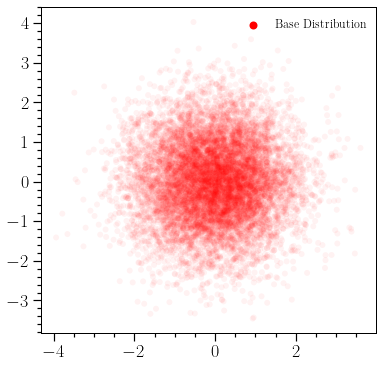

In [12]:
base_mu, base_cov = torch.zeros(2), torch.eye(2)
base_dist = MultivariateNormal(base_mu, base_cov)
base_dist = base_dist.sample(sample_shape = torch.Size([5*n_samples]))

fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(np.array(base_dist[:, 0]),np.array(base_dist[:, 1]),alpha = 0.05,color = 'red',edgecolor = 'none')
plt.scatter([],[],color = 'red',label = 'Base Distribution')
plt.legend()
plt.savefig("/Users/barbaraskrzypek/Documents/ZDist.png",dpi = 400,bbox_inches = "tight")
plt.show()

### Hyperparameters

In [33]:
target_data = torch.from_numpy(arr.T).float()

def simple_model(device = 'cpu'):
    return affine_coupling_flows(
        data_dim = target_data.size()[1],
        hidden_dim = 100,
        num_hidden = 1,
        num_flows = 5,
        num_params = 2,
        device = device
    ).to(device)

### Training Logic

In [14]:
def train(
    model: nn.Module,
    train_loader:DataLoader,
    num_epochs: int,
    args
) -> torch.Tensor:
    
    def _train(epoch, log_interval = 50):
        model.train()
        losses = torch.zeros(len(train_loader))
        for i,x in enumerate(train_loader):
            optimizer.zero_grad()
            loss = -model.log_prob(x.to(device)).mean()
            loss.backward()
            losses[i] = loss.item()
            optimizer.step()
            
        return losses.mean().item()
    
    def log_training_results(loss,epoch,log_interval):
        if epoch % log_interval == 0:
            print("Training Results - Epoch: {} Avg train loss: {:.2f}".format(epoch, loss))
            
    optimizer = torch.optim.AdamW(model.parameters(),lr = args['lr'])
    num_steps = len(train_loader)*num_epochs
    scheduler = StepLR(
        optimizer,
        step_size = args['lr_decay_interval'],
        gamma = args['lr_decay_rate']
    ) 
    
    train_losses = []
    for epoch in range(num_epochs+1):
        loss = _train(epoch)
        log_training_results(loss, epoch, log_interval = 100)
        train_losses.append(loss)
        scheduler.step()
        
    return train_losses

def train_new_model(data, num_epochs, args):
    np.random.seed(1)
    model = simple_model()
    loader = partial(DataLoader, batch_size = 32, shuffle = True)
    loss = train(
        model = model,
        train_loader = loader(data),
        num_epochs = num_epochs,
        args = args
    )
    
    return model, loss

In [15]:
np.shape(target_data)

torch.Size([2000, 2])

In [ ]:
args = {'lr_decay_interval': 20,
        'lr_decay_rate': .1,
        'lr': 1e-3}

#def target_class() -> torch.Tensor:
#    x = 

#target_data = torch.from_numpy(arr.T).float()

device = 'cpu'
train_with_args = partial(train_new_model, num_epochs = 100, args = args)
model, loss = train_with_args(target_data)

Training Results - Epoch: 0 Avg train loss: -9552.63


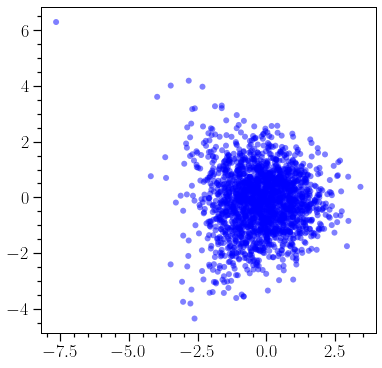

In [31]:
fig, ax = plt.subplots(figsize = (6,6))
prediction = model.sample(num_samples = 2000)
plt.scatter(prediction[:,0],prediction[:,1],color = 'blue',edgecolor = 'none', label = 'Prediction',alpha = 0.5)

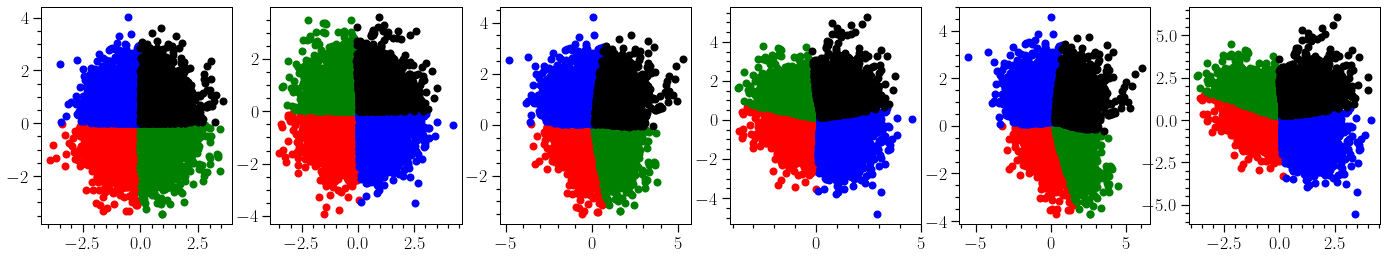

In [29]:
steps = model.g_steps(base_dist)
X0 = steps[0].detach().numpy()
f, arr = plt.subplots(1, len(steps), figsize=(4 * (len(steps)), 4))
for i in range(len(steps)): 
    X1 = steps[i].detach().numpy()
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], color='black')
    #arr[i].set_title("{}".format(model.flows[i]))
plt.savefig("/Users/barbaraskrzypek/Documents/NFTransformations.png",dpi = 400,bbox_inches = "tight")